In [1]:
%load_ext autotime

time: 272 µs (started: 2022-04-02 21:37:11 +05:30)


In [17]:
import torch
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from tqdm.auto import tqdm

import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs 
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterfactualProto

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.5.0
Eager execution enabled:  False
time: 3.88 ms (started: 2022-04-02 22:13:12 +05:30)


In [3]:
CLASS = tf.keras.datasets.fashion_mnist
ROOT = 'fmnist'

time: 540 µs (started: 2022-04-02 21:37:16 +05:30)


In [4]:
(x_train, y_train), (x_test, y_test) = CLASS.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()

x_train shape: (60000, 28, 28) y_train shape: (60000,)


<Figure size 432x288 with 0 Axes>

time: 513 ms (started: 2022-04-02 21:37:16 +05:30)


In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)
time: 64.1 ms (started: 2022-04-02 21:37:17 +05:30)


In [6]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

time: 197 ms (started: 2022-04-02 21:37:17 +05:30)


In [7]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

time: 1.34 ms (started: 2022-04-02 21:37:17 +05:30)


In [8]:
try:
    cnn = load_model(f'{ROOT}_cnn.h5')
except OSError:
    cnn = cnn_model()
    cnn.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1)
    cnn.save(f'{ROOT}_cnn.h5')
cnn.summary()
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Train on 60000 samples
Epoch 1/20


2022-04-02 21:37:18.169155: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-02 21:37:18.170733: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-02 21:37:18.204996: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


60000/60000 [==============================] - 69s 1ms/sample - loss: 0.6078 - acc: 0.7783
Epoch 2/20
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.4037 - acc: 0.8536
Epoch 3/20
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.3644 - acc: 0.8687
Epoch 4/20
60000/60000 [==============================] - 67s 1ms/sample - loss: 0.3396 - acc: 0.8759
Epoch 5/20
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.3223 - acc: 0.8812
Epoch 6/20
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.3040 - acc: 0.8901
Epoch 7/20
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.2909 - acc: 0.8934
Epoch 8/20
60000/60000 [==============================] - 53s 879us/sample - loss: 0.2803 - acc: 0.8968
Epoch 9/20
60000/60000 [==============================] - 39s 650us/sample - loss: 0.2720 - acc: 0.9002
Epoch 10/20
60000/60000 [==============================] - 40s 675us/sample - loss: 0.264

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Test accuracy:  0.925
time: 21min 11s (started: 2022-04-02 21:37:17 +05:30)


In [9]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)
    
    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)
    
    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder, decoder

time: 1.73 ms (started: 2022-04-02 21:58:28 +05:30)


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 58s 971us/sample - loss: 0.0168 - val_loss: 0.0068
Epoch 2/5
60000/60000 [==============================] - 59s 981us/sample - loss: 0.0059 - val_loss: 0.0054
Epoch 3/5
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.0051 - val_loss: 0.0049
Epoch 4/5
60000/60000 [==============================] - 56s 936us/sample - loss: 0.0047 - val_loss: 0.0047
Epoch 5/5
60000/60000 [==============================] - 58s 964us/sample - loss: 0.0045 - val_loss: 0.0045


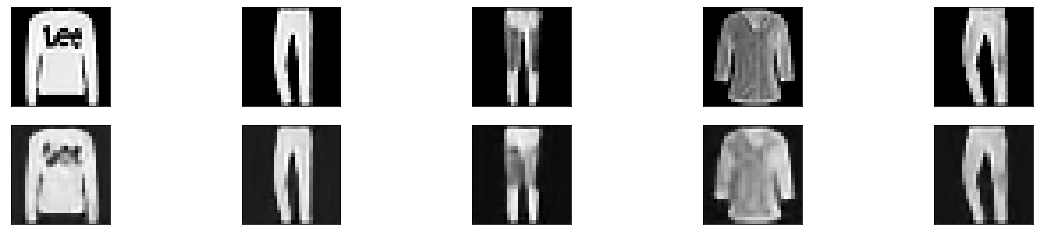

time: 4min 53s (started: 2022-04-02 21:59:03 +05:30)


In [11]:
try:
    ae = load_model(f'{ROOT}_ae.h5')
    enc = load_model(f'{ROOT}_enc.h5', compile=False)
except OSError:
    ae, enc, dec = ae_model()
    ae.fit(x_train, x_train, batch_size=128, epochs=5, validation_data=(x_test, x_test), verbose=1)
    ae.save(f'{ROOT}_ae.h5', save_format='h5')
    enc.save(f'{ROOT}_enc.h5', save_format='h5')

decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
test_sample = []
for i in range(10):
    test_sample.append(np.where(np.argmax(y_test, axis=-1) == i)[0][-1])
test_sample

[9981, 9998, 9985, 9984, 9989, 9999, 9991, 9986, 9997, 9995]

time: 7.93 ms (started: 2022-04-02 22:11:03 +05:30)


In [14]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 0.
c_steps = 1
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

time: 38.1 ms (started: 2022-04-02 22:11:08 +05:30)


In [15]:
predict_fn = lambda x: cnn.predict(x)
cf = CounterfactualProto(predict_fn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)

CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.1,
              'feature_range': (-0.5, 0.5),
              'gamma': 100.0,
              'theta': 100.0,
              'cat_vars': None,
              'ohe': False,
              'use_kdtree': False,
              'learning_rate_init': 0.01,
              'max_iterations': 1000,
              'c_init': 0.0,
              'c_steps': 1,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'shape': (1, 28, 28, 1),
              'is_model': False,
              'is_ae': True,
              'is_enc': True,
              'enc_or_kdtree': True,
              'is_cat': False,
              'trustscore_kwargs': None,
              'd_type': 'abdm',
              'w': None,
              '

time: 57.5 s (started: 2022-04-02 22:11:09 +05:30)


In [18]:
grid = []
avg_time = 0
for input_class in tqdm(range(10), 'input class'):
    X = x_test[test_sample[input_class]].reshape((1,) + x_test[0].shape)
    
    grid.append(torch.as_tensor(X.reshape(1, 28, 28)))
    for target_class in tqdm(range(10), 'target class'):

        start_time = time()
        explanation = cf.explain(X, k=1, target_class=[target_class])
        avg_time += time() - start_time

        try:
            img = explanation.cf['X']
        except:
            img = np.ones((28, 28))

        grid.append(torch.as_tensor(img.reshape(1, 28, 28)))

avg_time /= 100
print(f'Avg. time: {avg_time} s')

input class:   0%|          | 0/10 [00:00<?, ?it/s]

target class:   0%|          | 0/10 [00:00<?, ?it/s]

No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!


target class:   0%|          | 0/10 [00:00<?, ?it/s]

No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!


target class:   0%|          | 0/10 [00:00<?, ?it/s]

No counterfactual found!
No counterfactual found!
No counterfactual found!


target class:   0%|          | 0/10 [00:00<?, ?it/s]

No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!


target class:   0%|          | 0/10 [00:00<?, ?it/s]

No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!


target class:   0%|          | 0/10 [00:00<?, ?it/s]

No counterfactual found!
No counterfactual found!


target class:   0%|          | 0/10 [00:00<?, ?it/s]

No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!


target class:   0%|          | 0/10 [00:00<?, ?it/s]

No counterfactual found!
No counterfactual found!


target class:   0%|          | 0/10 [00:00<?, ?it/s]

No counterfactual found!


target class:   0%|          | 0/10 [00:00<?, ?it/s]

No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!
No counterfactual found!


Avg. time: 10.248606169223786 s
time: 17min 6s (started: 2022-04-02 22:13:16 +05:30)


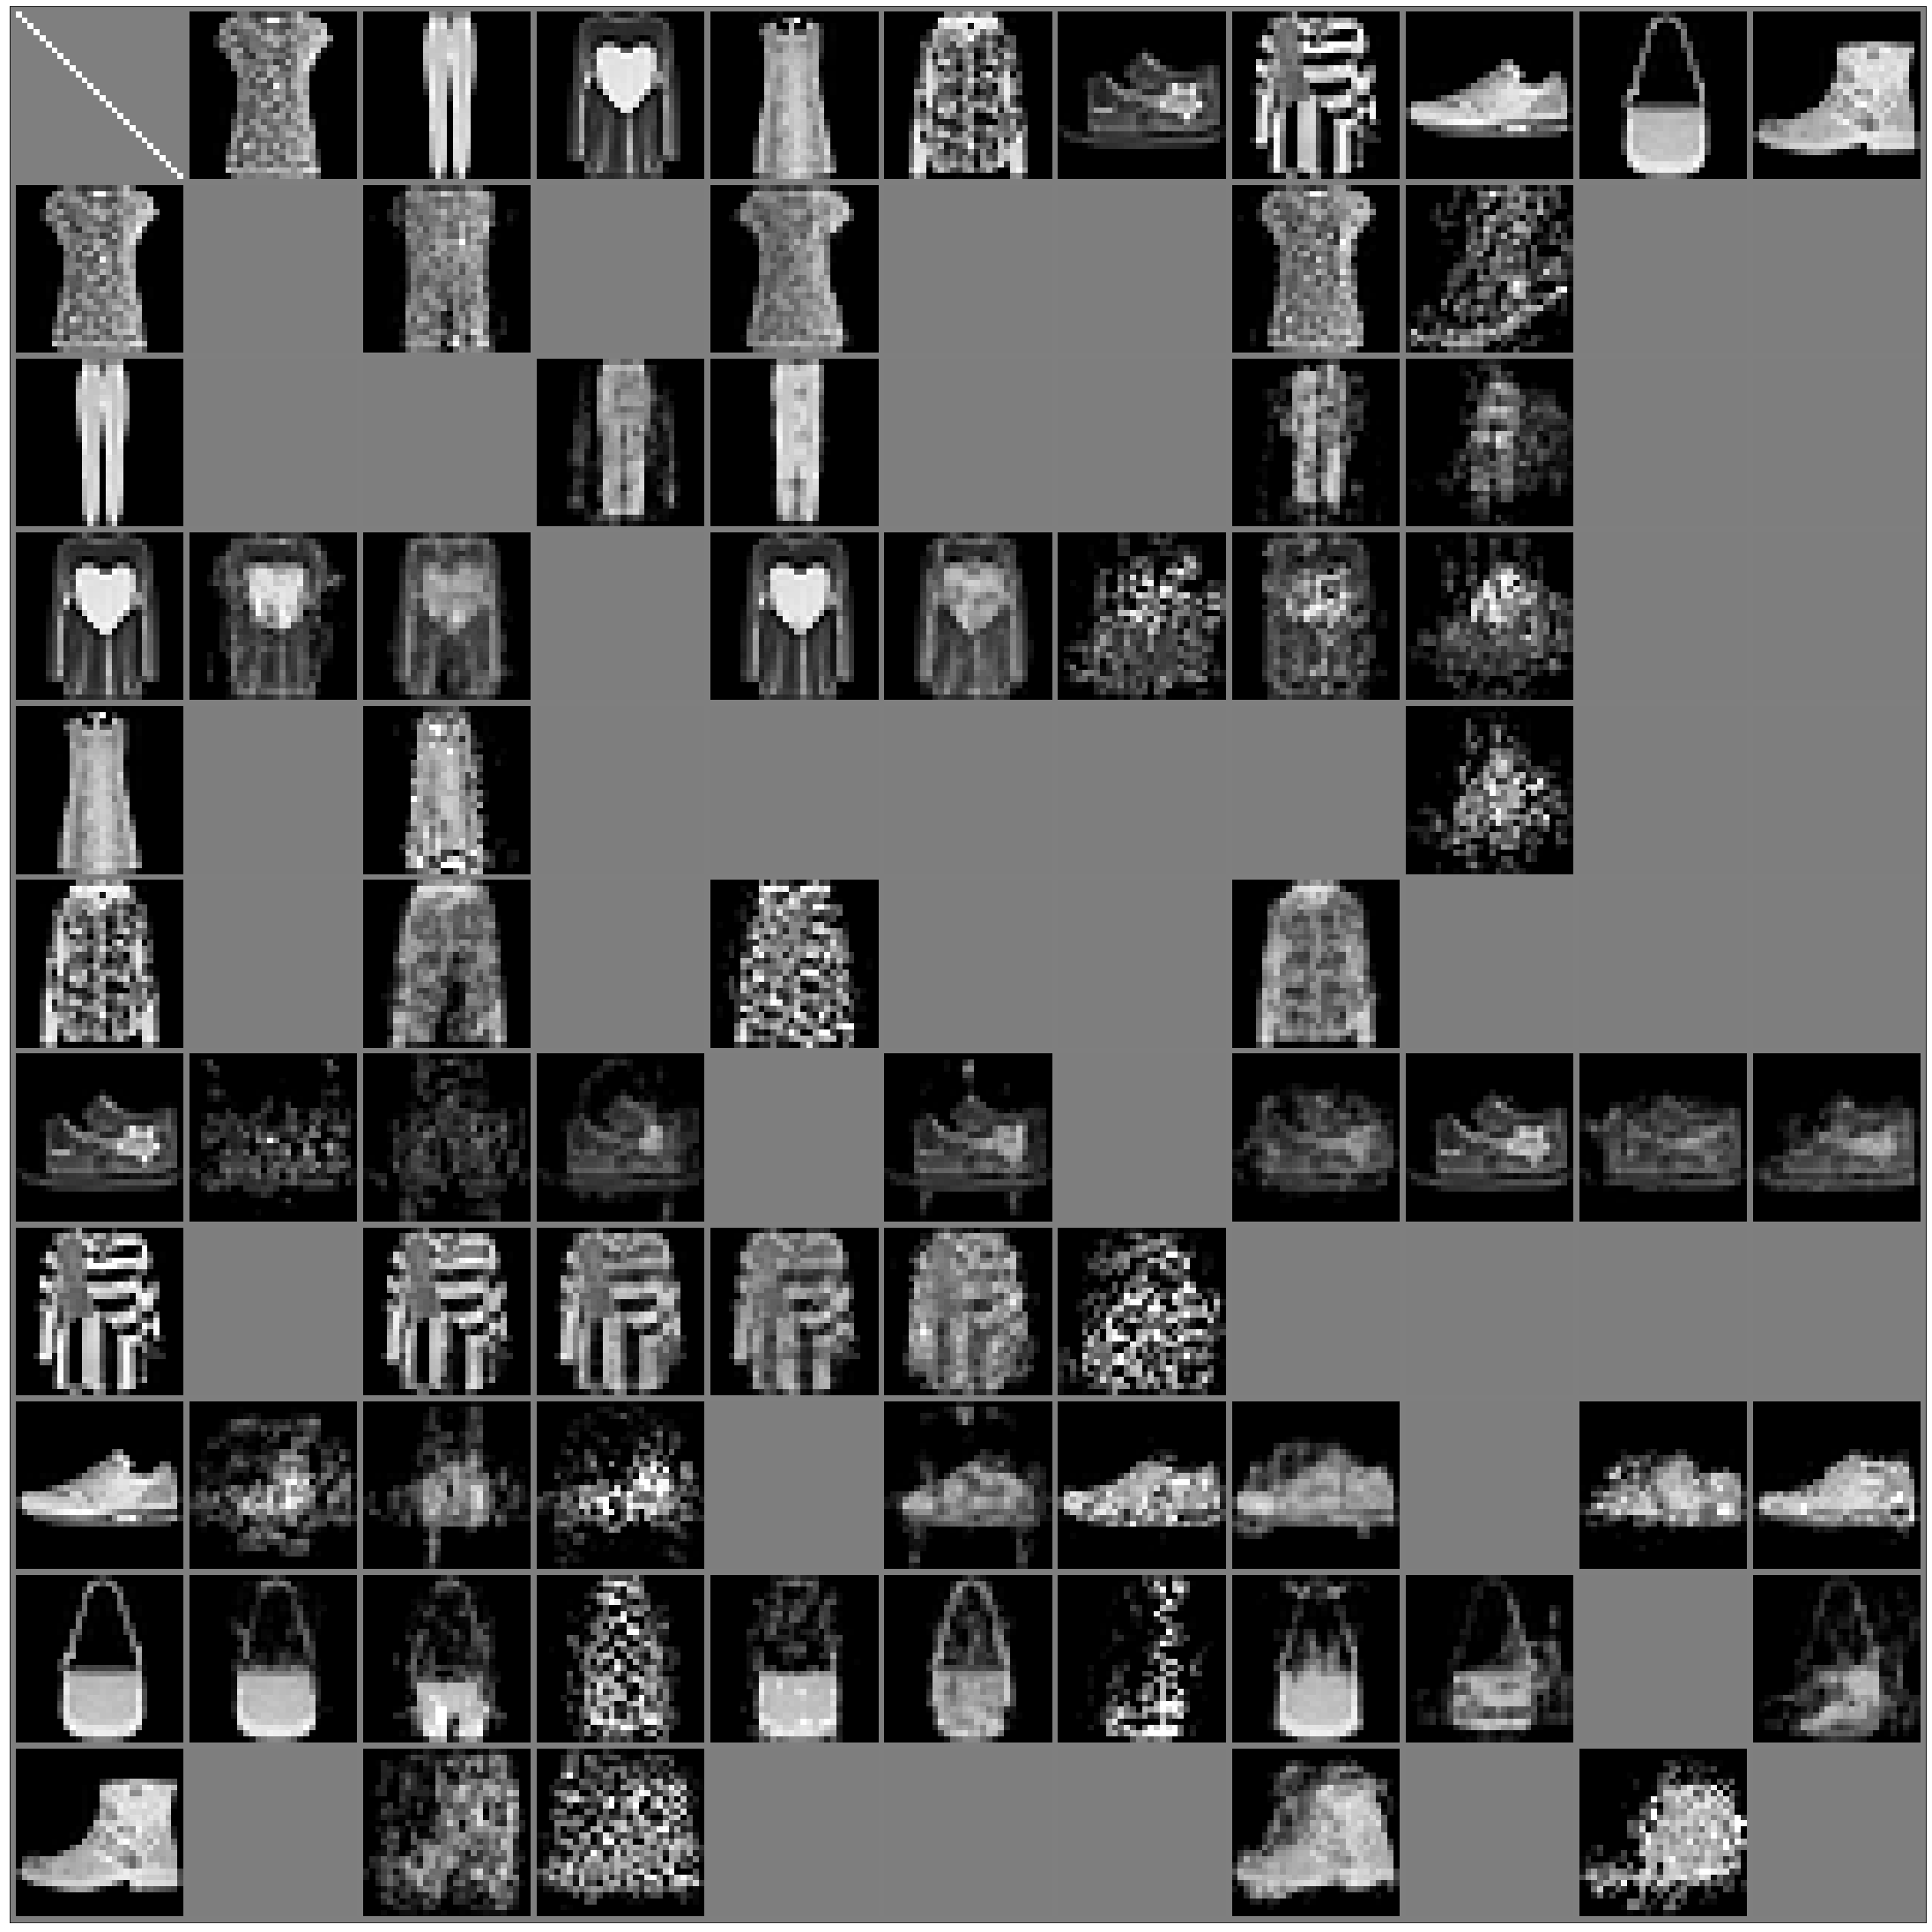

time: 908 ms (started: 2022-04-02 22:41:15 +05:30)


In [19]:
new_grid = [0.5 * torch.eye(28).reshape(1, 28, 28)] + [torch.as_tensor(x_test[test_sample[i]].reshape(1, 28, 28)) for i in range(10)] + grid
img = make_grid(torch.stack(new_grid), nrow=11, padding=1) + 0.5
plt.figure(figsize=(44, 40))
plt.gca().set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.imshow(np.asarray(F.to_pil_image(img)))
plt.savefig(f'{ROOT}_cfproto.eps', bbox_inches='tight')
plt.show()